   0 Microsoft Sound Mapper - Input, MME (2 in, 0 out)
>  1 Microphone (USB Audio Device ), MME (2 in, 0 out)
   2 Stereo-mix (Realtek(R) Audio), MME (2 in, 0 out)
   3 Microphone Array (Realtek(R) Au, MME (2 in, 0 out)
   4 Microphone (Camo), MME (2 in, 0 out)
   5 Microsoft Sound Mapper - Output, MME (0 in, 2 out)
<  6 Speakers (USB Audio Device ), MME (0 in, 2 out)
   7 Speaker/Headphone (Realtek(R) A, MME (0 in, 2 out)
   8 Primary Sound Capture Driver, Windows DirectSound (2 in, 0 out)
   9 Microphone (USB Audio Device ), Windows DirectSound (2 in, 0 out)
  10 Stereo-mix (Realtek(R) Audio), Windows DirectSound (2 in, 0 out)
  11 Microphone Array (Realtek(R) Audio), Windows DirectSound (2 in, 0 out)
  12 Microphone (Camo), Windows DirectSound (2 in, 0 out)
  13 Primary Sound Driver, Windows DirectSound (0 in, 2 out)
  14 Speakers (USB Audio Device ), Windows DirectSound (0 in, 2 out)
  15 Speaker/Headphone (Realtek(R) Audio), Windows DirectSound (0 in, 2 out)
  16 ASIO4ALL v2, ASIO

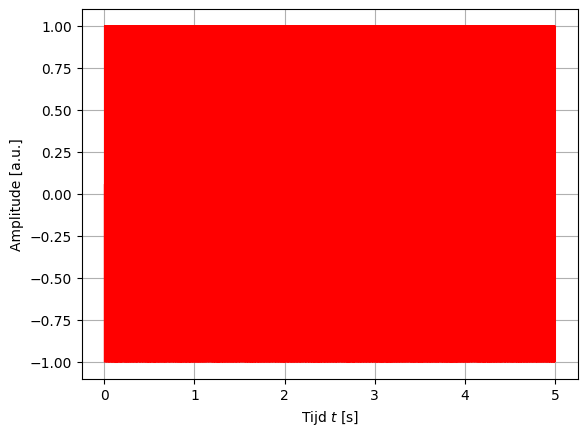

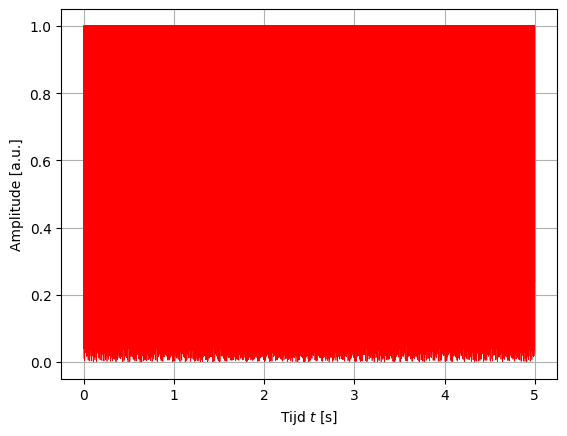

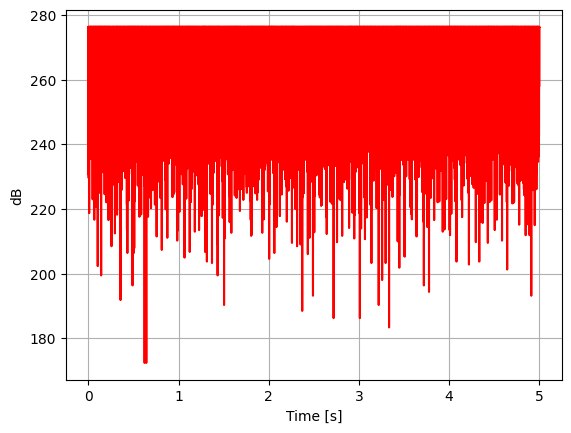

avg:274.5882799577277
max:276.3102111592855


In [27]:
import sounddevice as sd
import matplotlib.pyplot as plt
import numpy as np
from mijngeluid import fft_partitioned # zet mijngeluid.py in dezelfde folder als je notebook
import math
#import pandas as pd

def debug_sound_devices():
    print(sd.query_devices()) # geeft een lijst met devices en de bijbehorende nummers

def record(duration_in_seconds):  
    fs = 44100 # sample rate, zie microfoon specificaties
    duration = duration_in_seconds # in seconden
    _arr = sd.rec(int(duration * fs), samplerate=fs, channels=1, dtype='float64', device=1) # neemt op in de achtergrond
    sd.wait() # returns wanneer sd.rec() klaar is
    return _arr[:,0], duration, fs

def plot_amplitude_against_time(_duration, _fs, _values, _time_stamps):
    plt.figure(dpi=100)
    plt.plot(_time_stamps, _values, 'r-', ms=0.5, lw=0.5)
    plt.grid()
    plt.xlabel(r"Tijd $t$ [s]")
    plt.ylabel(r"Amplitude [a.u.]") # arbitrary units (we hebben niets gekalibreerd)

# def partition_with_time(_arr, _sample_rate, _duration):
#     return fft_partitioned(_arr, _sample_rate, _duration, t_bin=1e-2) # t_bin is de bin grootte in seconden

def calculate_decibels(_intensity_array, _decibel_offset):
    # return 10*np.log10(_intensity_array)
    y2 = _intensity_array.tolist()

    y2 = np.array(y2)
    y2[y2==0]=1e-12

    y3 = y2.tolist()
    y4 = []
    I_0 = 10**(-12)
    for I in y3:
        y4.append((10*(math.log(I/I_0))) + _decibel_offset)
    return y4

def plot_decibel_against_time(_time_stamps, _decibel_array):
    plt.figure(dpi=100)
    plt.plot(_time_stamps, _decibel_array, 'r-') # plot dB against time
    plt.grid()
    plt.xlabel("Time [s]")
    plt.ylabel("dB")
    plt.show()

debug_sound_devices()

# Step 1 record
values, duration, sample_rate = record(5)
# Create time stamps for plotting
time_stamps = np.linspace(0, duration, int(sample_rate*duration))
# Debug amplitude against time
plot_amplitude_against_time(_duration=duration, _fs=sample_rate, _values=values, _time_stamps=time_stamps)

# Step 2: Convert to absolute values
absolute_values = np.absolute(values)
plot_amplitude_against_time(_duration=duration, _fs=sample_rate, _values=absolute_values, _time_stamps=time_stamps)

decibel_array = calculate_decibels(_intensity_array=absolute_values, _decibel_offset=0)
plot_decibel_against_time(_time_stamps=time_stamps, _decibel_array=decibel_array)

print("avg:" + str(np.average(decibel_array)))

In [11]:
def get_reverb_time(_time_stamps, _decibel_array):
    # Find the maximum sound level in the decibel array
    max_sound_level = np.max(_decibel_array)

    # Find the index of the maximum sound level in the decibel array
    max_sound_level_index = np.argmax(_decibel_array)

    # Find the index of the first data point where the sound level is 60 dB below the maximum sound level
    decay_point_index = np.argmax((_decibel_array <= max_sound_level - 60) & (_time_stamps > _time_stamps[max_sound_level_index]))

    # Calculate the time it takes for the sound level to decay by 60 dB
    reverb_time = _time_stamps[decay_point_index] - _time_stamps[max_sound_level_index]

    return reverb_time

print("reverbation time: ")
print(str(get_reverb_time(np.array(df.t), decibel_array)))

reverbation time: 
0.010000000000000231
